# Data preparation
This code is to prepare the data for data preprocessing. The data is first exported from software LabChart ".adicht" file to ".txt" file, and the separte file will be transformed into a time series ".csv" file. After this, all the data from one object will be combined into a single time series ".csv" file.

Sample data is no.17273, date:10-11-2017 to 20-11-2017; 
## 1. export the raw data from LabChart
> First the raw data is export from software LabChart into .txt file with:
> * Necessary labels (comments from the software)
> * Channel:TP-AmnP (Featal respiration rate without noise), FHR (Fetal heart rate, which is the cyclic measurement of artery blood pressure)
> * Parameters: Output NaN for values, Time (always seconds), Date, Ignore regional options
> * Downsample: to 0.5s/ponit (if 2k/s choose 1000, if 1k/s choose 500)

## 2. transform .txt into pd.dataframe
> After that, load the data into a pd.dataframe:
> * load all libraries & specify the path to the data
> * specify column names & transform the raw data into correct dtype

In [80]:
#load libraries
from datetime import datetime, timedelta
from dateutil import parser
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
import csv
import os

#specify the data dir
data_file = '/Users/leeo/Desktop/KI2/7.master_thesis/1.data/17273_txt/17273_12-11-17.txt'

In [81]:
#load the data 
data = pd.read_csv(data_file, sep="\t", header=None, 
                   names=["Time","Date","HR","Resp","Comments"])#cautious of each column
#turn date and time into pd.timedelta and datetime
data['Time'] = pd.to_timedelta(data['Time'], "s")
data['Date'] = pd.to_datetime(data['Date'])
print("Please check the values and data type for each column! If anything wrong, please recheck the channels!(HR should be more than 100)")
print(data.dtypes)
data.head()

Please check the values and data type for each column! If anything wrong, please recheck the channels!(HR should be more than 100)
Time        timedelta64[ns]
Date         datetime64[ns]
HR                  float64
Resp                float64
Comments            float64
dtype: object


,Time,Date,HR,Resp,Comments
0,14:46:55.121100,2017-11-12,145.1701,0.403788,NaN
1,14:46:55.621100,2017-11-12,146.3960,0.833938,NaN
2,14:46:56.121100,2017-11-12,148.1785,2.054920,NaN
3,14:46:56.621100,2017-11-12,148.5241,1.648533,NaN
4,14:46:57.121100,2017-11-12,148.0627,1.265892,NaN


## 3. transform the data into time series
> * combine the date and time into Date_Time
> * transform the data into time series
> * check the time intervals of data

In [82]:
#fix the format for output
data = data.reindex(columns=["Time","Date","HR","Resp","Comments"])
#combine the date and time
data['Date_Time'] = data['Date']+data['Time']
del data['Date'], data['Time']

#tranform the time into index
data.index = data['Date_Time'] 
del data['Date_Time'] 

# check time intervals
set_time_intervals = pd.Timedelta("0.5s")
actual_time_intervals = data.index[1] -data.index[0]
if (set_time_intervals != actual_time_intervals):
    print("The time intervals now is:", actual_time_intervals, ". Please check the downsample parameter!!")
    
data.tail()

,HR,Resp,Comments
Date_Time,,,
2017-11-13 10:19:23.121100,162.4292,3.154878,NaN
2017-11-13 10:19:23.621100,168.8280,5.427113,NaN
2017-11-13 10:19:24.121100,164.9334,5.253589,NaN
2017-11-13 10:19:24.621100,166.7716,5.016145,NaN
2017-11-13 10:19:25.121100,165.1504,4.386994,NaN


## 4. check and handle missing values
> * chech the sparsity of the data
> * compute missing values with carry-forward (backforward if needed) method
> * check the computation situation

In [83]:
#Check the number of missing values
missing_total=data.isnull().sum().sum()
missing_HR=data["HR"].isnull().sum()
missing_Resp=data["Resp"].isnull().sum()
print("There are {} missings in total, and {} for HR, {} for Resp.".format(missing_total, missing_HR, missing_Resp))
if missing_HR > 20:
    raise Exception('Missing values of HR should not exceed 20.')
if missing_Resp > 20:
    raise Exception('Missing values of Resp should not exceed 20.')

There are 140701 missings in total, and 0 for HR, 0 for Resp.


In [84]:
#compute missing values with carry forward method
data["HR"].fillna(method='ffill', inplace =True)
data["Resp"].fillna(method='ffill', inplace =True)
data["HR"].fillna(method='bfill', inplace =True)
data["Resp"].fillna(method='bfill', inplace =True)
#check the computation situation
missing_total=data.isnull().sum().sum()
missing_HR=data["HR"].isnull().sum()
missing_Resp=data["Resp"].isnull().sum()
print("There are {} missings in total, and {} for HR, {} for Resp.".format(missing_total, missing_HR, missing_Resp))
if missing_HR != 0:
    raise Exception('Something wrong with missing values computing of HR.')
if missing_Resp != 0:
    raise Exception('Something wrong with missing values computing of Resp.')

There are 140701 missings in total, and 0 for HR, 0 for Resp.


## 5. quick exploration of data

In [85]:
#check the comments for label
data["Comments"][data["Comments"].isnull()==False]

Series([], Name: Comments, dtype: float64)

The shape of data is:  (140701, 3)


Text(2017-11-12 10:24:03.020700, 0, 'comment time')

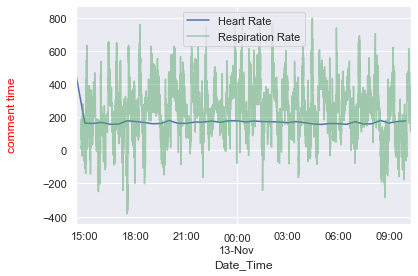

In [86]:
t0 = pd.to_datetime("2017-11-12 10:24:03.020700") #starting time for sepsis

#quick look at the data
print("The shape of data is: ", data.shape)
data["HR"].resample("30T").mean().plot(color="b",alpha=1)
(data["Resp"]*100).resample("10S").mean().plot(color="g",alpha=0.5)
plt.legend(["Heart Rate", "Respiration Rate"],
          loc="upper center")
plt.axvline(t0, alpha=0.8, color ="red")
plt.text(t0, 0,'comment time', color ="red",rotation=90)

In [87]:
#Export the data
new_path = os.path.dirname(os.path.dirname(data_file))+"/"+os.path.dirname(data_file)[-9:-3]+"ts/"+data_file[-18:-4]+".csv"
export_csv = data.to_csv (new_path, header=True)

In [55]:
#slice the data if needed
#data["Comments"][data["Comments"].isnull()==False]
#data = data.loc[:"2017/11/20 9:58:35.4395"]

## 6. combine all data files of one object
After all single time series from the same object have been transformed, execute this block to combine them into one single file.

In [139]:
from os import listdir
from os.path import isfile, join
ts_dir = '/Users/leeo/Desktop/KI2/7.master_thesis/1.data/17273_ts'

combined_data = []
for f in listdir(ts_dir):
    file_path = ts_dir+"/"+f
    data = pd.read_csv(file_path, sep=",", header=0,
                   parse_dates=[0], index_col=0)
    # store DataFrame in list
    combined_data.append(data)
#concat all data in one
combined_data = pd.concat(combined_data).sort_index()

In [140]:
#check the comments for label
combined_data["Comments"][combined_data["Comments"].isnull()==False]

Date_Time
2017-11-11 10:24:03.020700                                          #* Comment 
2017-11-13 10:40:53.355800                        #* LPS 300ng IV Jugular Vein 
2017-11-13 10:41:21.355800    #* Rob is looking very cute today in a tight s...
2017-11-13 12:17:16.855800                                                 #*  
2017-11-13 15:50:10.855800                                                 #*  
2017-11-14 08:43:00.261200                                        #* 600ng LPS 
2017-11-14 09:07:52.261200                          #* finish giving 600ng lps 
2017-11-15 08:19:43.826900                   #2 1.2ug LPS dose given at 8:00am 
2017-11-20 07:27:32.439200    #* blood gas + lps in next 10 mins (300ng/2mL ...
2017-11-20 07:49:36.939200              #* finish giving lps to 17-257 (300ng) 
Name: Comments, dtype: object

The shape of data is:  (1289630, 3)


Text(2017-11-15 08:19:43.826900, -1000, '3rd injection')

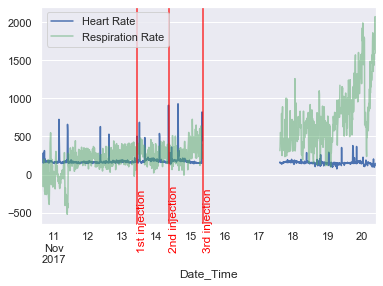

In [170]:
t1 = pd.to_datetime("2017-11-13 10:40:53.355800") 
t2 = pd.to_datetime("2017-11-14 08:43:00.261200") 
t3 = pd.to_datetime("2017-11-15 08:19:43.826900") 

#quick look at the data
print("The shape of data is: ", combined_data.shape)
combined_data["HR"].resample("10T").mean().plot(color="b",alpha=1)
(combined_data["Resp"]*100).resample("10T").mean().plot(color="g",alpha=0.5)
plt.legend(["Heart Rate", "Respiration Rate"],
          loc="upper left")
plt.axvline(t1, alpha=0.8, color ="red")
plt.text(t1,-1000,'1st injection', color ="red",rotation=90)
plt.axvline(t2, alpha=0.8, color ="red")
plt.text(t2,-1000,'2nd injection', color ="red",rotation=90)
plt.axvline(t3, alpha=0.8, color ="red")
plt.text(t3,-1000,'3rd injection', color ="red",rotation=90)

In [152]:
#Export the data
object_path = ts_dir[:-8]+"2.object_data_combined/"+ts_dir[-8:-3]+".csv"
export_csv = combined_data.to_csv(object_path, header=True)